In [1]:
import numpy as np
import pandas as pd
import os
from pypinyin import pinyin, lazy_pinyin, Style
import matplotlib.pyplot as plt
import econtools.metrics as mt
import matplotlib
import seaborn as sns
from matplotlib import font_manager

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['font.family'] = ['Heiti TC']

### NSFC data

In [2]:
qn_all = pd.read_csv("/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/qn_all.csv")
qn_all['nsfc_code'] = qn_all['申请代码'].str[0:1]
#qn_all['nsfc_code'].value_counts()
qn_all['立项年份'] = qn_all['年份']*qn_all['立项']
qn_all = pd.DataFrame(qn_all.groupby(['申请人','申请部门','nsfc_code']).立项年份.max()).reset_index()

In [3]:
def pinyin(name):
    i = lazy_pinyin(name)
    if len(i) == 3:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1]+i[2])]
    elif len(i) == 2:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1])]
    else:
        #print(i)
        capitalized = i
    return capitalized
def surname(name):
    i = lazy_pinyin(name)
    if len(i) == 3:
        capitalized = str.capitalize(i[0])
    elif len(i) == 2:
        capitalized = str.capitalize(i[0])
    else:
        #print(i)
        capitalized = i[0]
    return capitalized
def givenname(name):
    i = lazy_pinyin(name)
    if len(i) == 3:
        capitalized = str.capitalize(i[1]+i[2])
    elif len(i) == 2:
        capitalized = str.capitalize(i[1])
    else:
        #print(i)
        capitalized = i[0]
    return capitalized

In [4]:
qn_all['pinyin']= qn_all['申请人'].apply(pinyin)
qn_all['surname'] = qn_all['申请人'].apply(surname)
qn_all['givenname'] = qn_all['申请人'].apply(givenname)
qn_all['author_name'] = qn_all['surname']+' '+qn_all['givenname']
qn_nsfc = qn_all.groupby(by=['申请人','申请部门','nsfc_code','author_name'])['立项年份'].sum().reset_index()[['申请人','author_name','申请部门','立项年份']]
qn_nsfc.head(5)

,申请人,author_name,申请部门,立项年份
0,Bagrat Mailyan,Bagrat Mailyan Bagrat Mailyan,威海校区,2014
1,LIU YI,LIU YI LIU YI,国际创新转化学院,0
2,Munish Kumar Gupta,Munish Kumar Gupta Munish Kumar Gupta,机械工程学院,0
3,Najib Ahmad Muhammad,Najib Ahmad Muhammad Najib Ahmad Muhammad,材料学院,0
4,Shani Tiwari,Shani Tiwari Shani Tiwari,环境研究院,0


In [5]:
qn_all.立项年份.value_counts()

立项年份
0       1058
2022     162
2021     147
2019     109
2020     106
2016      64
2014      60
2013      58
2017      56
2018      53
2015      47
Name: count, dtype: int64

### Publication data

- Consolidate all publications with unique author eid
- Consolidate all author_eids
- Merge the two using author_eid 
- Reshape to wide format

### 读取文章数据

In [6]:
root_dir = "/Users/yansong/Nutstore Files/论文发表2013-2020/scopusPub/dta"
authors = os.listdir(root_dir)
os.chdir(root_dir)
lists_pubs = []
for author_file in authors:
    if '.dta' in author_file:
        author_pubs = pd.read_stata(author_file)
        if 'school 1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'school 1']]
            author_pubs.rename(columns={'school 1':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)
            
        elif 'school1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'school1']]
            author_pubs.rename(columns={'school1':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)
            
        elif 'school1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'school']]
            author_pubs.rename(columns={'school':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)
        else:
            print(author_file)
qn_pubs = pd.concat(lists_pubs)    
qn_pubs.head(1)

,affilname,afid,author_eid,author_names,citedby_count,coverDate,doi,eid,title,school_1
0,Shandong First Medical University &amp; Shando...,60161479;60092862;60031419;60031031,55981883200,"Jin, Yecheng;Gao, Xiaotong;Lu, Miaoqing;Chen, ...",0,10/10/2022,10.1093/hmg/ddac127,2-s2.0-85139803890,Loss of BAF (mSWI/SNF) chromatin-remodeling AT...,山大二院


In [7]:
qn_pubs['author_eid'] = pd.to_numeric(qn_pubs['author_eid'], errors='coerce')
type(qn_pubs['author_eid'].iloc[0])

numpy.float64

In [8]:
len(authors)

1215

### 读取作者信息

In [9]:
root_dir = "/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/scopus"
authors = os.listdir(root_dir)
os.chdir(root_dir)
unique_lists = []

for author_file in authors:
    if '.csv' in author_file:
        author_pubs = pd.read_csv(author_file)
        unique_lists.append(author_pubs)

author_ids = pd.concat(unique_lists)
author_ids['author_eid']= author_ids['eid'].str.split("-").str.get(2)
author_ids['author_eid'] = author_ids['author_eid'].astype('int64')
author_ids.drop(columns=['eid'],inplace=True)
author_ids.head(1)

,Unnamed: 0,orcid,surname,initials,givenname,affiliation,documents,affiliation_id,city,country,areas,author_eid
0,0,NaN,Shen,Z.,Zhongjian,Shandong University,6,60031031,Jinan,China,ENVI (6); SOCI (2); AGRI (2),57213191602


In [10]:
len(author_ids.author_eid.unique())

5297

### 匹配作者和文章(merge on author_eid)

In [11]:
qn_author_pubs = qn_pubs.merge(author_ids,how='left',on='author_eid',indicator=True)
qn_author_pubs['year'] = qn_author_pubs['coverDate'].str[-4:]
qn_author_pubs['author_name'] = qn_author_pubs['surname']+' ' +qn_author_pubs['givenname']
qn_author_pubs._merge.value_counts()

_merge
both          117189
left_only         42
right_only         0
Name: count, dtype: int64

In [12]:
qn_author_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')
qn_author_pubs['citations'] = pd.to_numeric(qn_author_pubs['citedby_count'], errors='coerce')
qn_author_pubs['coauthors'] = qn_author_pubs.author_names.str.count(';')

### 转换为 author by year data

In [13]:
qn_author_year_pubs4 = qn_author_pubs.groupby(['author_name','school_1','year'])['author_names'].apply('/'.join).reset_index()
qn_author_year_pubs4['unique_coauthors'] = qn_author_year_pubs4.author_names.str.count(';')

#qn_author_pubs['coauthors'] = qn_author_pubs.author_names.str.count(';')

qn_author_year_pubs3 = qn_author_pubs.groupby(['author_name','school_1','year'])['coauthors'].mean().reset_index()

qn_author_year_pubs2 = qn_author_pubs.groupby(['author_name','school_1','year'])['citations'].sum().reset_index()

qn_author_year_pubs1 = qn_author_pubs.groupby(['author_name','school_1','year'])['author_eid'].count().reset_index()

qn_author_year_pubs  = qn_author_year_pubs1.merge(qn_author_year_pubs2,how='left',
                                                  on=['author_name','school_1','year'],indicator=True)
qn_author_year_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')

qn_author_year_pubs = qn_author_year_pubs.merge(qn_author_year_pubs3,how='left',
                                                  on=['author_name','school_1','year'],indicator=True)
qn_author_year_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')

qn_author_year_pubs = qn_author_year_pubs.merge(qn_author_year_pubs4,how='left',
                                                  on=['author_name','school_1','year'],indicator=True)
qn_author_year_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')


In [14]:
# pub_scatter = qn_author_year_pubs.groupby(['year']).author_eid.mean().reset_index()
# # pub_scatter = pub_scatter.loc[4:23,:] # select between 2003 and 2022
# pub_scatter['year'] = pd.to_numeric(pub_scatter['year'], errors='coerce')
# pub_scatter.drop(pub_scatter.loc[pub_scatter['year']<2003].index, inplace=True)
# pub_scatter.drop(pub_scatter.loc[pub_scatter['year']>2022].index, inplace=True)
# matplotlib.style.use('bmh') 
# fig, ax = plt.subplots(figsize=(8,6))
# scatter = ax.scatter(pub_scatter.year, pub_scatter.author_eid,cmap='tab20b')
# plt.xticks([2005,2010,2015,2020])
# plt.show()

In [15]:
# matplotlib.style.use('bmh') 
# #.hist(normed=True)
# plt.hist(np.clip(qn_author_year_pubs.groupby(['author_name']).author_eid.mean(),0,10))

## 合并基金与论文数据(on author_name, 申请部门)
    ☐ 第一步: 仅使用 unique 的作者姓名的数据进行匹配

    ☐ 第二步: 对剩下的重名的部分，使用姓名和院系进行匹配

    ☐ 第三步: 合并第一步，和第二步所得到的数据

    ☐ 检查每一步匹配的结果

In [40]:
qn_author_year_pubs.rename(columns={'school_1':'申请部门'},inplace=True)
qn_author_year_pubs['year'] = pd.to_numeric(qn_author_year_pubs['year'], errors='coerce')
qn_author_year_pubs.drop(qn_author_year_pubs.loc[qn_author_year_pubs['year']<2003].index, inplace=True)
qn_author_year_pubs.drop(qn_author_year_pubs.loc[qn_author_year_pubs['year']>2022].index, inplace=True)

###    ☐ 第一步: 仅使用 unique 的作者姓名的数据进行匹配

In [33]:
len(set(list(qn_nsfc.author_name)))

1727

In [34]:
qn_nsfc_no_dup = qn_nsfc.drop_duplicates('author_name')
qn_nsfc_no_dup

,申请人,author_name,申请部门,立项年份
0,Bagrat Mailyan,Bagrat Mailyan Bagrat Mailyan,威海校区,2014
1,LIU YI,LIU YI LIU YI,国际创新转化学院,0
2,Munish Kumar Gupta,Munish Kumar Gupta Munish Kumar Gupta,机械工程学院,0
3,Najib Ahmad Muhammad,Najib Ahmad Muhammad Najib Ahmad Muhammad,材料学院,0
4,Shani Tiwari,Shani Tiwari Shani Tiwari,环境研究院,0
...,...,...,...,...
1915,齐楠,Qi Nan,海洋研究院,2019
1916,齐璐,Qi Lu,前沿交叉科学青岛研究院,2021
1917,齐美苓,Qi Meiling,护理与康复学院,0
1918,齐超,Qi Chao,威海校区,0


In [46]:
qn_nsfc_pubs = qn_author_year_pubs.merge(qn_nsfc_no_dup,how='outer',on=['author_name'],indicator=True)
print(qn_nsfc_pubs._merge.value_counts())
qn_nsfc_pubs = qn_nsfc_pubs[qn_nsfc_pubs['_merge']=='both']
print(qn_nsfc_pubs.shape)
qn_nsfc_pubs.reset_index().head(1)

_merge
both          14511
left_only       763
right_only      589
Name: count, dtype: int64
(14511, 12)


,index,author_name,申请部门_x,year,author_eid,citations,coauthors,author_names,unique_coauthors,申请人,申请部门_y,立项年份,_merge
0,0,Bai Caiquan,经济研究院,2015.0,3.0,3.0,4.0,"Bai, Caiquan;He, Yiqing;Zhou, Decai;Zhang, Yi;...",12.0,白彩全,经济研究院,2022.0,both


In [49]:
len(set(list(qn_nsfc_pubs.author_name)))

1138

### Output data for regressions

In [52]:
qn_nsfc_pubs['grant_t'] = qn_nsfc_pubs['year'].astype('int64')-qn_nsfc_pubs['立项年份']
qn_nsfc_pubs.loc[qn_nsfc_pubs['立项年份']==0,'grant_t'] = 0
qn_nsfc_pubs['after_grant'] = qn_nsfc_pubs['grant_t'] >0
qn_nsfc_pubs['after_grant'] = qn_nsfc_pubs['after_grant'].astype('int64')

limit = qn_nsfc_pubs['author_eid'].quantile(0.99)
limit
qn_nsfc_pubs = qn_nsfc_pubs[qn_nsfc_pubs['author_eid']<=limit]

qn_nsfc_pubs.to_csv("/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/qn_reg_type1_coded.csv")

## 期刊分区数据
- 先把论文发表的期刊名字匹配起来
- 再和JCR期刊分区匹配起来
- 再进行transform
- 和自科数据合并
- 输出文件，在stata内进行回归

In [44]:
root_dir = "/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/scopusPub_New/dta"
os.chdir(root_dir)
authors = os.listdir(root_dir)
unique_lists = []

for author_file in authors:
    if '.dta' in author_file:
        author_pubs = pd.read_stata(author_file)
        unique_lists.append(author_pubs)

pub_names = pd.concat(unique_lists)
pub_names = pub_names[['eid','author_eid','publicationname']]

In [45]:
def extract_journal(journal_name):

    # get the index of the separator 
    # if index = -1, return entire string
    # if index != -1, return from index to end of string 
    sep_index = journal_name.rfind('/')+1
    if sep_index == 0:
        journal_eng = journal_name 
    else:
        journal_eng = journal_name[sep_index:]
    return journal_eng
pub_names['journal_name'] = pub_names['publicationname'].apply(extract_journal)

In [46]:
qn_df = qn_author_pubs.merge(pub_names,how='left',on=['eid','author_eid'],indicator=True)
qn_df.drop(columns='_merge',inplace=True)

In [47]:
root_dir = "/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青"
os.chdir(root_dir)
JCR2022 = pd.read_stata("JCR2022.dta")
JCR2022 = JCR2022[['journal_group','j_group1','j_group2','j_group3','j_group4','journal_name']]

In [48]:
qn_df = qn_df.merge(JCR2022,how='left',on=['journal_name'],indicator=True)

In [49]:
qn_df._merge.value_counts()

_merge
left_only     89437
both          32676
right_only        0
Name: count, dtype: int64

In [50]:
qn_df['counter'] = 1

In [51]:
qn_df_grouped = qn_df.groupby(['author_name','school_1','year'])[['j_group1','j_group2','j_group3','j_group4','counter']].sum().reset_index()


In [52]:
qn_df_grouped.head(1)

,author_name,school_1,year,j_group1,j_group2,j_group3,j_group4,counter
0,Bai Caiquan,经济研究院,2015,0.0,0.0,0.0,0.0,3


In [53]:
qn_df_grouped['year'] = pd.to_numeric(qn_df_grouped['year'], errors='coerce')
qn_df_grouped.drop(qn_df_grouped.loc[qn_df_grouped['year']<2003].index, inplace=True)
qn_df_grouped.drop(qn_df_grouped.loc[qn_df_grouped['year']>2022].index, inplace=True)
qn_df_grouped.rename(columns={'school_1':'申请部门'},inplace=True)

In [54]:
qn_nsfc_df = qn_df_grouped.merge(qn_nsfc,how='inner',on=['author_name','申请部门'],indicator=True)

In [55]:
qn_nsfc_df.to_csv("/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/qn_reg_type3.csv")

## 描述性图

/var/folders/kp/gk4kvr5s0plbp5y3112cx_x00000gn/T/ipykernel_60791/3616614756.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(pub_grant_scatter.grant_t, pub_grant_scatter.author_eid,cmap='tab20b')


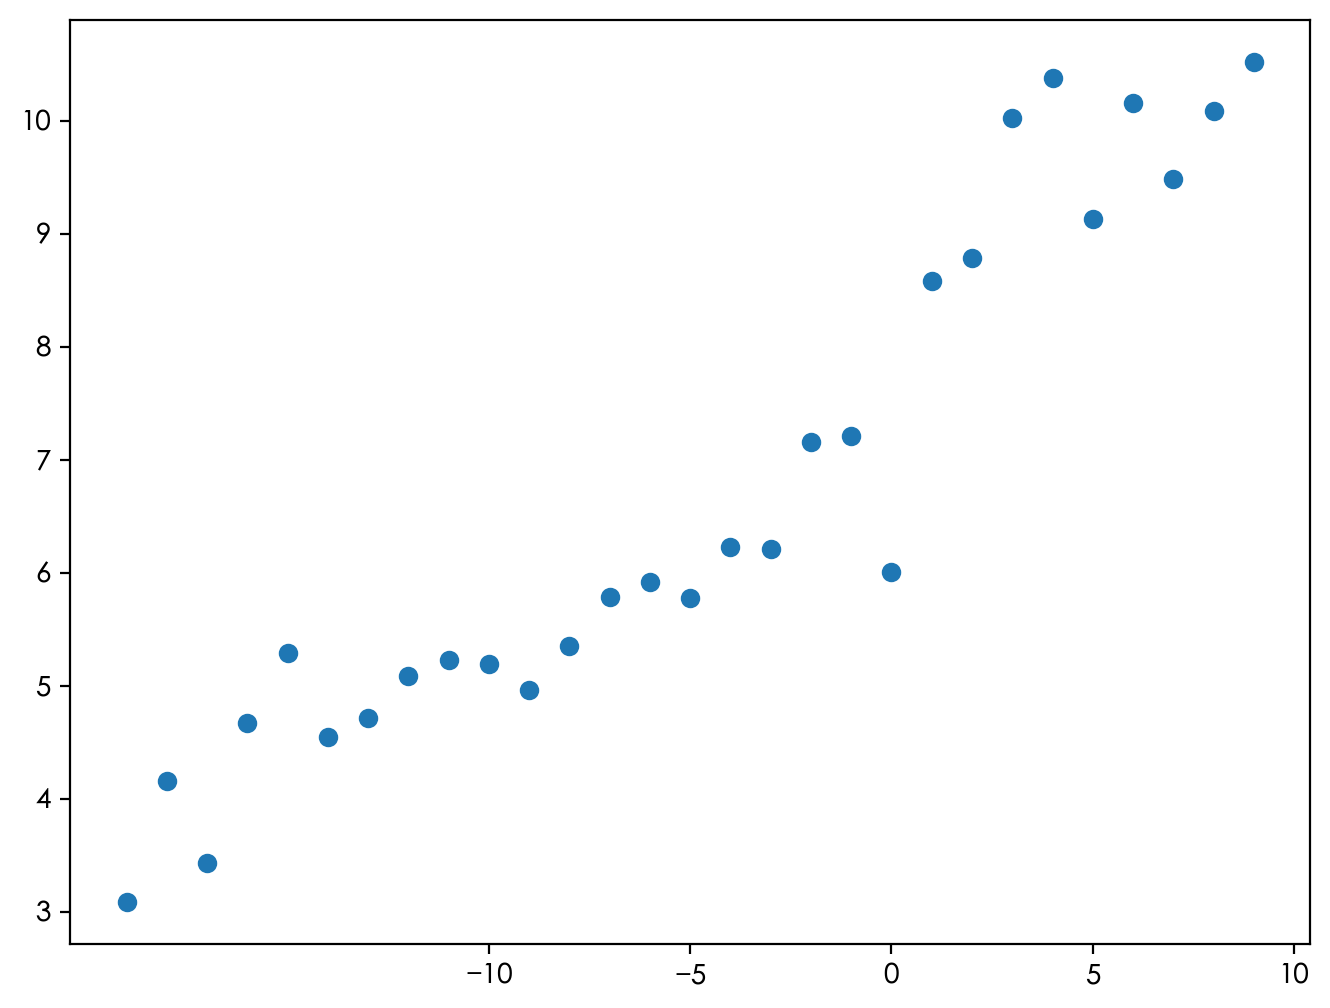

In [51]:
pub_grant_scatter = qn_nsfc_pubs.groupby(['grant_t']).author_eid.mean().reset_index()

fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(pub_grant_scatter.grant_t, pub_grant_scatter.author_eid,cmap='tab20b')
plt.xticks([-10,-5,0,5,10])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


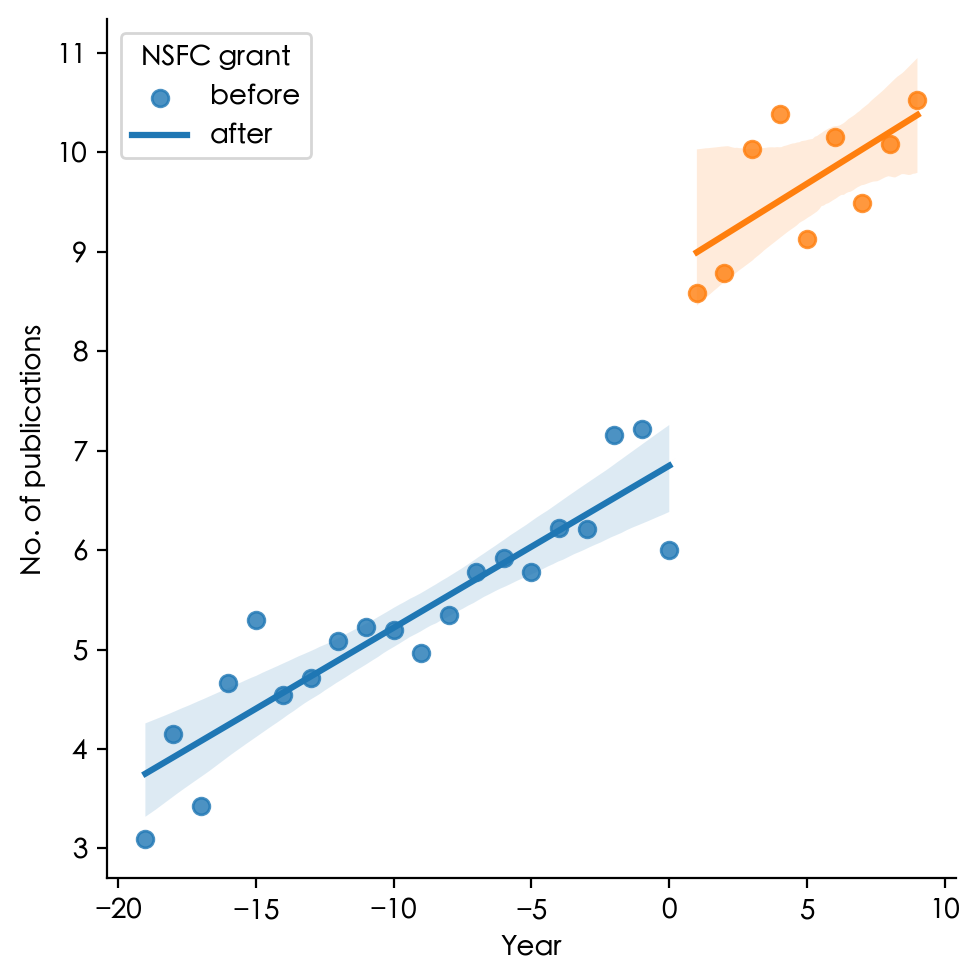

In [53]:
pub_grant_scatter['after_grant'] = pub_grant_scatter['grant_t'] >0 
#sns.regplot(x=pub_grant_scatter.grant_t, y=pub_grant_scatter.author_eid)
g = sns.lmplot(data = pub_grant_scatter, x='grant_t', y='author_eid',hue='after_grant',legend=False)
plt.legend(title='NSFC grant', loc='upper left', labels=['before', 'after'])
plt.xlabel('Year')
plt.ylabel('No. of publications')

plt.show(g)
g.savefig('/Users/yansong/Nutstore Files/基金研究/graph_updated/pub_bf_af.png')